### Working Demand Matrix Generation using Grid2Demand
This notebook demonstrates how to use grid2demand to build a travel demand matrix for any urban area.

In [2]:
# 1. Setup and Imports
import os

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox

import grid2demand as gd
import osm2gmns as og

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Ensure Directory Location and Existence

# Create output directory
output_dir = 'network_data_testing'
os.makedirs(output_dir, exist_ok=True)
osm_filepath = f"{output_dir}/map.osm"

In [ ]:
# OPTIONAL: Download and Visualize OpenStreetMap Network Data using OSMnx to download the street network

# Download street network from OpenStreetMap
print("Downloading street network from OpenStreetMap...")
print("This may take a few minutes...\n")

# Define the place name for the study area
place_name = "Brooklyn, New York City, New York, USA"  # CHANGE THIS to your study area

# Use place name to download network
# OSMnx will query the Nominatim API to get the boundaries
G = ox.graph_from_place(
    place_name,
    network_type='drive'  # Only drivable roads
)

# TODO - Clean network using OSMNx tools

print(f"✓ Network downloaded successfully!")
print(f"  Nodes (intersections): {len(G.nodes):,}")
print(f"  Edges (road segments): {len(G.edges):,}")

# Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
print(f"\n✓ Converted to GeoDataFrames")
print(f"  Nodes GDF: {len(nodes_gdf)} rows")
print(f"  Edges GDF: {len(edges_gdf)} rows")

# Visualize the downloaded network
fig, ax = plt.subplots(figsize=(10, 15))

# Plot edges (roads)
edges_gdf.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.7, label='Roads')

# Plot nodes (intersections)
nodes_gdf.plot(ax=ax, markersize=0.5, color='red', alpha=0.5, label='Nodes')

ax.set_title('Street Network', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Network visualization complete!")

In [ ]:
"""# 4b. PATH-A: Save OSM Network Data for Grid2Demand - Custom Parser


# Create output directory
output_dir = 'network_data'
os.makedirs(output_dir, exist_ok=True)

# Prepare node data with all required columns for grid2demand
node_data = pd.DataFrame({
    'node_id': range(len(nodes_gdf)),
    'osm_node_id': nodes_gdf.index,
    'x_coord': nodes_gdf.geometry.x,
    'y_coord': nodes_gdf.geometry.y,
    'longitude': nodes_gdf.geometry.x,
    'latitude': nodes_gdf.geometry.y,
    'activity_type': 'node',  # Required by grid2demand
    'is_boundary': 0,  # 0 = internal node, 1 = boundary node
    'zone_id': -1  # Will be assigned when zones are created
})

# Save node data
node_file = os.path.join(output_dir, 'node.csv')
node_data.to_csv(node_file, index=False)
print(f"✓ Saved node data: {node_file}")
print(f"  Total nodes: {len(node_data):,}")

# Create OSM to sequential node ID mapping
osm_to_seq = dict(zip(nodes_gdf.index, range(len(nodes_gdf))))

# Prepare link data with required columns
links = []
for idx, (u, v, key, data) in enumerate(G.edges(keys=True, data=True)):
    # Parse lanes - handle various formats
    lanes = data.get('lanes', 1)
    if isinstance(lanes, list):
        lanes = int(lanes[0]) if lanes else 1
    elif isinstance(lanes, str):
        try:
            lanes = int(lanes.split(';')[0])  # Take first value if multiple
        except:
            lanes = 1
    else:
        try:
            lanes = int(lanes)
        except:
            lanes = 1
    
    link = {
        'link_id': idx,
        'from_node_id': osm_to_seq[u],
        'to_node_id': osm_to_seq[v],
        'length': data.get('length', 0),  # in meters
        'lanes': lanes,
        'capacity': int(lanes * 1800),  # 1800 vehicles per hour per lane
        'free_speed': 35,  # default 35 mph
        'link_type': str(data.get('highway', 'residential')),
        'geometry': ''  # Optional: can add WKT geometry string
    }
    links.append(link)

link_data = pd.DataFrame(links)

# Save link data
link_file = os.path.join(output_dir, 'link.csv')
link_data.to_csv(link_file, index=False)
print(f"✓ Saved link data: {link_file}")
print(f"  Total links: {len(link_data):,}")

# Create a dummy POI file with all required columns for grid2demand
# Based on error, grid2demand expects: geometry, building, centroid, amenity
dummy_poi = pd.DataFrame({
    'poi_id': [0],
    'x_coord': [node_data['longitude'].mean()],
    'y_coord': [node_data['latitude'].mean()],
    'longitude': [node_data['longitude'].mean()],
    'latitude': [node_data['latitude'].mean()],
    'poi_type': ['placeholder'],
    'name': ['placeholder'],
    'area': [100.0],
    'zone_id': [-1],
    'geometry': ['POINT(0 0)'],  # WKT format
    'building': ['yes'],
    'centroid': ['POINT(0 0)'],
    'amenity': ['placeholder']
})
poi_file = os.path.join(output_dir, 'poi.csv')
dummy_poi.to_csv(poi_file, index=False)
print(f"✓ Created placeholder POI file: {poi_file}")

print(f"\n✓ Network data saved to: {output_dir}/")"""

In [ ]:
# 4a. PATH-B: Select, Download, and Save OSM Network Data for Grid2Demand Using osm2gmns Library

# OSM Area ids
# search at: nominatim.openstreetmap.org
brooklyn_id = 369518
antwerp_id = 53114
brussels_id = 2404020
ghent_id = 897671
lviv_id = 2032280

# Download directly from OSM
print("Downloading OSM network...")
og.downloadOSMData(brooklyn_id, osm_filepath)


In [ ]:
# 4b. PATH-B: Open OSM, extract, convert, and save GMNS file

# Open OSM, convert to GMNS, and clean as desired
print("Loading and converting OSM network to GMNS...")
net = og.getNetFromFile(osm_filepath, mode_types='auto', POI=True)
og.fillLinkAttributesWithDefaultValues(net)
#og.consolidateComplexIntersections(net, auto_identify=True)

# Save to CSV files in GMNS format
og.outputNetToCSV(net, output_dir)

print(f"  Nodes: {net.number_of_nodes:,}")
print(f"  Links: {net.number_of_links:,}")

In [ ]:
# 5. Initialize, Load Grid2Demand Network

# Initialize grid2demand network
print("Initializing grid2demand network...\n")

# Create a GRID2DEMAND object (newer API)
net = gd.GRID2DEMAND(input_dir=output_dir)

# Load the network files
net.load_network()

print(f"✓ Network loaded successfully!")
print(f"  Nodes: {len(net.node_dict):,}")
print(f"  POIs: {len(net.poi_dict):,}")
# Note: link information is stored differently in grid2demand
if hasattr(net, 'link_dict'):
    print(f"  Links: {len(net.link_dict):,}")
elif hasattr(net, 'link_list'):
    print(f"  Links: {len(net.link_list):,}")

In [ ]:
# 6. Create Grid-Based Zones - Grid2demand will partition the area into grid-based zones (TAZs)

# Generate zone.csv from node by specifying number of x blocks and y blocks
net.net2grid(num_x_blocks=12, num_y_blocks=12)
#net.net2grid(cell_width=2000, cell_height=500, unit="meter")

# Load zone from zone.csv
net.taz2zone()

# Map zones with nodes and poi, viseversa
net.map_zone_node_poi()

# Calculate zone-to-zone distance matrix
net.calc_zone_od_distance(pct=1.0)


In [ ]:
# 7. Calculate demand by running gravity model - save results (overwriting orig files)
net.run_gravity_model()

net.save_results_to_csv(zone_od_dist_matrix=True, demand_od_matrix=True, overwrite_file=True)

Testing Brooklyn basemap with zone boxes, numbers, and OD pairs...
Loaded 110 zones
Note: No population column in zone.csv
Filtered to 104 zones with demand
Calculating combined bidirectional trips...
✓ Selected top 200 OD pairs by combined volume
✓ Plotted 200 OD pairs
  Line width range: 1.0 - 6.0
✓ Added 104 zone labels with POI counts
Adding basemap...


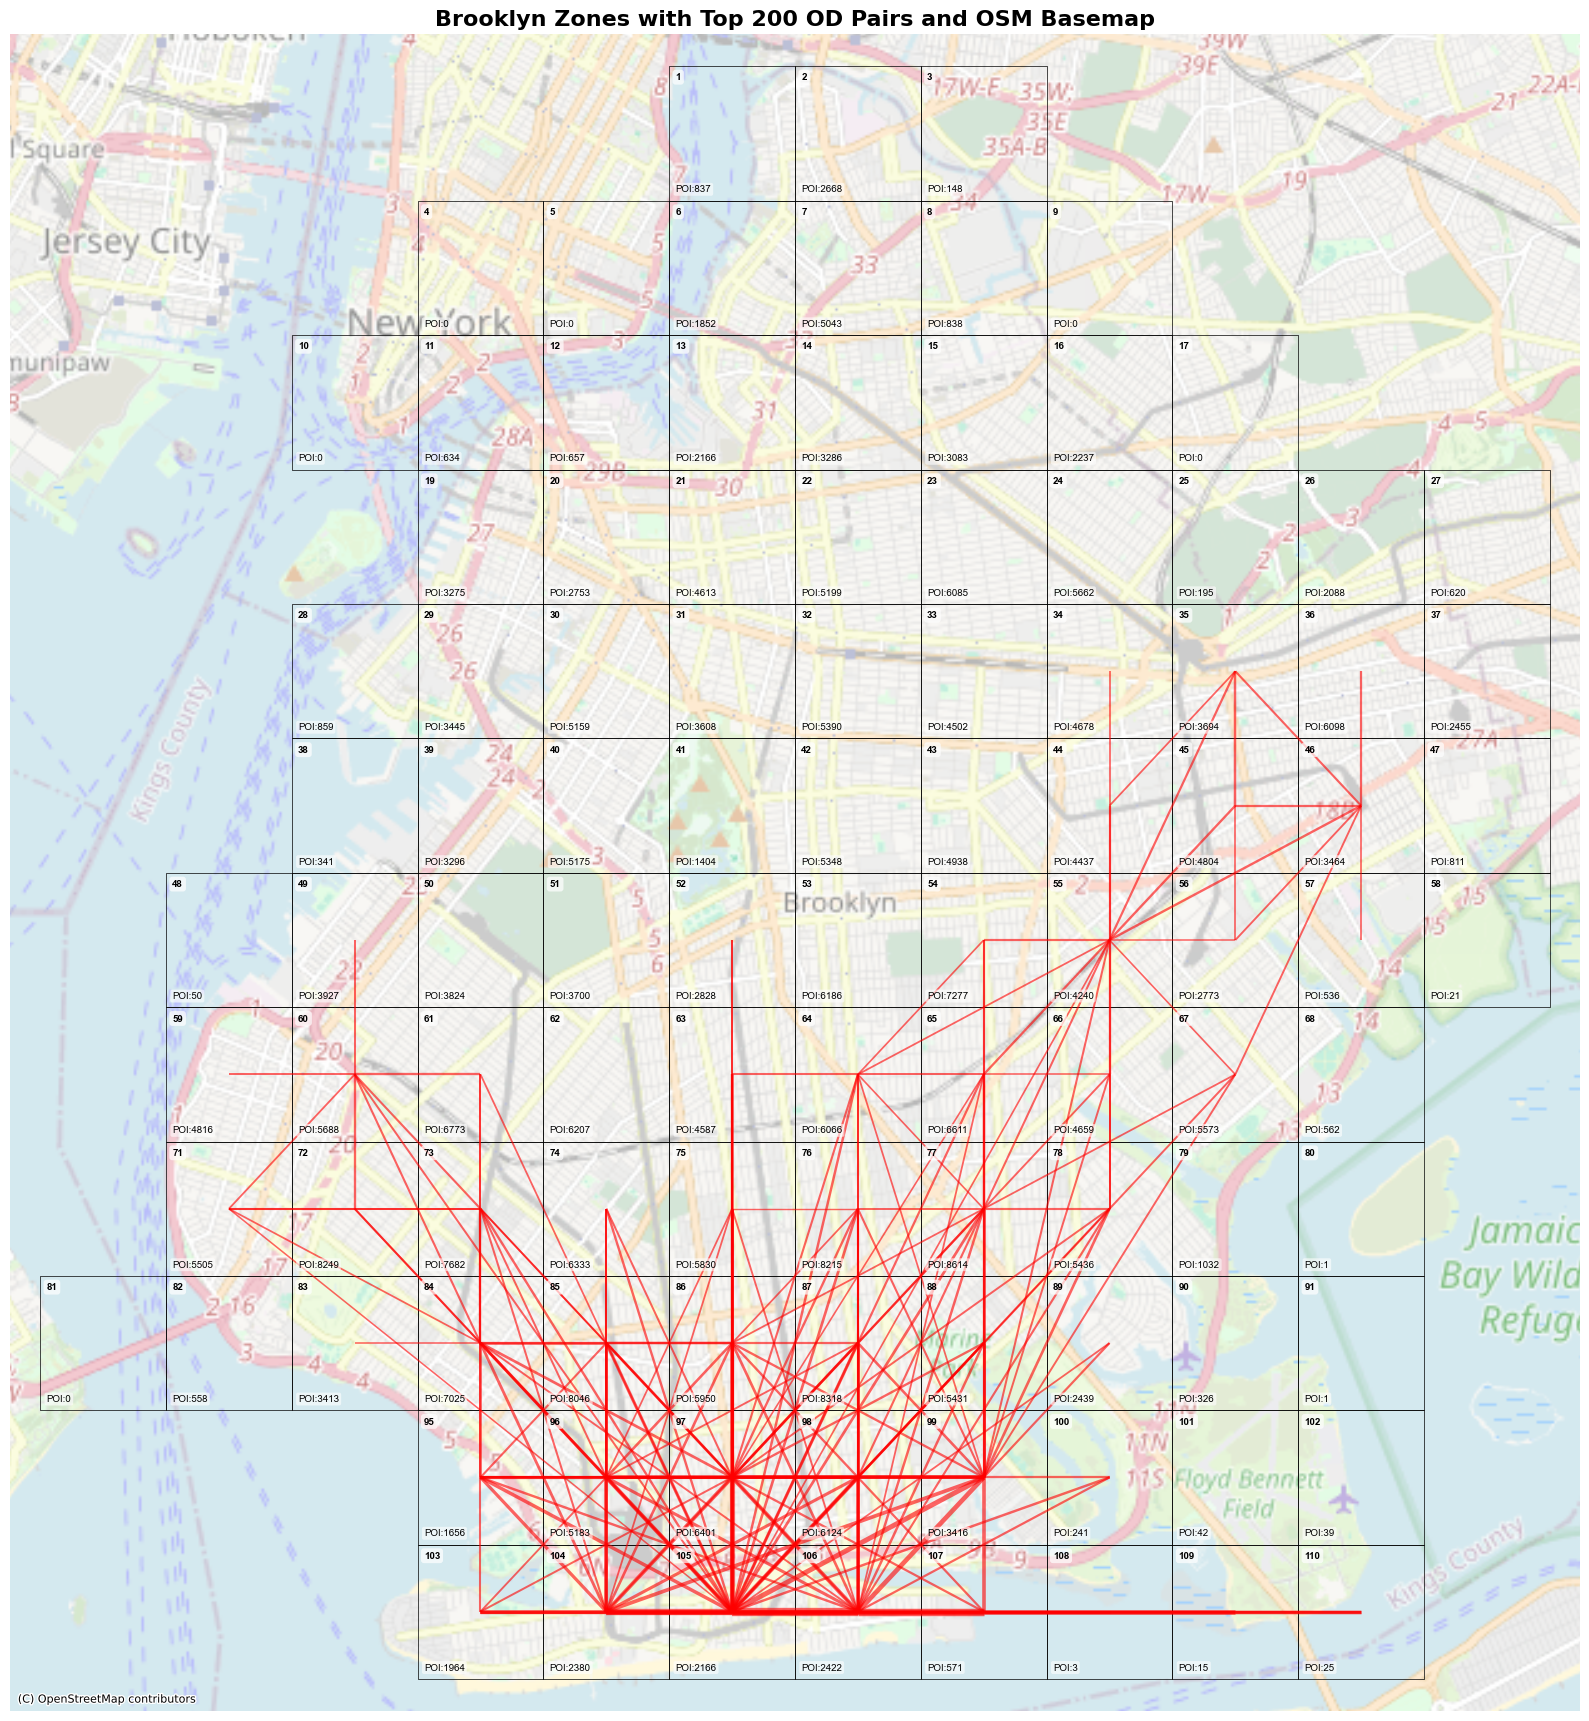

✓ Test complete!
  104 zone boxes plotted
  200 OD pairs plotted
  Top 200 volume range: 1217 - 23623


In [ ]:
# Basemap with Zone Boxes, Numbers, OD Pairs, and POI Counts

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from matplotlib.collections import LineCollection
import numpy as np

print("Testing Brooklyn basemap with zone boxes, numbers, and OD pairs...")

# Get Brooklyn boundary (for extent calculation only)
place_name = "Brooklyn, New York City, New York, USA"
brooklyn_boundary = ox.geocode_to_gdf(place_name)

# Load zone data
zone_df = pd.read_csv(os.path.join(output_dir, 'zone.csv'))
print(f"Loaded {len(zone_df)} zones")

# Check if population data exists
has_population = 'population' in zone_df.columns
if has_population:
    print(f"✓ Population data found in zone.csv")
else:
    print(f"Note: No population column in zone.csv")

# Filter to zones with demand
demand_df = pd.read_csv(os.path.join(output_dir, 'demand.csv'))
zones_with_demand = set()
zones_with_demand.update(demand_df[demand_df['volume'] > 0]['o_zone_id'].unique())
zones_with_demand.update(demand_df[demand_df['volume'] > 0]['d_zone_id'].unique())
zone_df_filtered = zone_df[zone_df['zone_id'].isin(zones_with_demand)].copy()
print(f"Filtered to {len(zone_df_filtered)} zones with demand")

# Calculate combined A-B + B-A trips for each OD pair
print("Calculating combined bidirectional trips...")
od_combined = []
processed_pairs = set()

for _, row in demand_df.iterrows():
    o_zone = row['o_zone_id']
    d_zone = row['d_zone_id']
    
    if (d_zone, o_zone) in processed_pairs or o_zone == d_zone:
        continue
    
    reverse_trip = demand_df[(demand_df['o_zone_id'] == d_zone) & 
                             (demand_df['d_zone_id'] == o_zone)]
    
    volume_ab = row['volume']
    volume_ba = reverse_trip['volume'].values[0] if len(reverse_trip) > 0 else 0
    
    od_combined.append({
        'zone_a': o_zone,
        'zone_b': d_zone,
        'combined_volume': volume_ab + volume_ba
    })
    
    processed_pairs.add((o_zone, d_zone))

od_combined_df = pd.DataFrame(od_combined)
top_200_od = od_combined_df.nlargest(200, 'combined_volume')
print(f"✓ Selected top 200 OD pairs by combined volume")

# Load actual zone polygons from the geometry column
zone_df_filtered['polygon_geometry'] = zone_df_filtered['geometry'].apply(wkt.loads)
zone_poly_gdf = gpd.GeoDataFrame(
    zone_df_filtered[['zone_id']],
    geometry=zone_df_filtered['polygon_geometry'],
    crs='EPSG:4326'
)

# Create zone centroids
zone_centroids = gpd.GeoDataFrame(
    zone_df_filtered,
    geometry=gpd.points_from_xy(zone_df_filtered['x_coord'], zone_df_filtered['y_coord']),
    crs='EPSG:4326'
)

# Convert to Web Mercator
brooklyn_merc = brooklyn_boundary.to_crs(epsg=3857)
zone_poly_merc = zone_poly_gdf.to_crs(epsg=3857)
zone_centroids_merc = zone_centroids.to_crs(epsg=3857)

# Create bigger plot with tight margins
fig, ax = plt.subplots(figsize=(16, 20))

# Plot zone boxes (this sets the extent)
zone_poly_merc.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=1.0, zorder=3)

# Set tight axis limits based on zone bounds with minimal margin
zone_bounds = zone_poly_merc.total_bounds  # (minx, miny, maxx, maxy)
margin_x = (zone_bounds[2] - zone_bounds[0]) * 0.02  # 2% margin
margin_y = (zone_bounds[3] - zone_bounds[1]) * 0.02  # 2% margin
ax.set_xlim(zone_bounds[0] - margin_x, zone_bounds[2] + margin_x)
ax.set_ylim(zone_bounds[1] - margin_y, zone_bounds[3] + margin_y)

# Plot top 200 OD pairs as lines
lines = []
widths = []

max_volume = top_200_od['combined_volume'].max()
min_volume = top_200_od['combined_volume'].min()

from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

for _, od_row in top_200_od.iterrows():
    zone_a = zone_df_filtered[zone_df_filtered['zone_id'] == od_row['zone_a']]
    zone_b = zone_df_filtered[zone_df_filtered['zone_id'] == od_row['zone_b']]
    
    if len(zone_a) == 0 or len(zone_b) == 0:
        continue
    
    zone_a = zone_a.iloc[0]
    zone_b = zone_b.iloc[0]
    
    x1, y1 = transformer.transform(zone_a['x_coord'], zone_a['y_coord'])
    x2, y2 = transformer.transform(zone_b['x_coord'], zone_b['y_coord'])
    
    line = [(x1, y1), (x2, y2)]
    lines.append(line)
    
    # Scale line width with better differentiation for medium values
    # Using power scaling to spread out medium values more (1.0 to 6.0 range)
    normalized_volume = (od_row['combined_volume'] - min_volume) / (max_volume - min_volume)
    # Apply square root to compress high values and expand medium values
    width = 1.0 + (normalized_volume ** 0.5) * 5.0
    widths.append(width)

lc = LineCollection(lines, linewidths=widths, colors='red', alpha=0.6, zorder=4)
ax.add_collection(lc)

print(f"✓ Plotted {len(lines)} OD pairs")
print(f"  Line width range: 1.0 - 6.0")

# Add zone numbers and data labels
from matplotlib import font_manager
for idx, row in zone_poly_merc.iterrows():
    zone_id = row['zone_id']
    
    # Get corresponding zone data from filtered dataframe
    zone_data = zone_df_filtered[zone_df_filtered['zone_id'] == zone_id].iloc[0]
    
    # Get the bounds of this zone polygon
    bounds = row.geometry.bounds  # (minx, miny, maxx, maxy)
    
    # Upper left corner - Zone ID
    x_upper_left = bounds[0] + (bounds[2] - bounds[0]) * 0.05  # 5% from left edge
    y_upper_left = bounds[3] - (bounds[3] - bounds[1]) * 0.05  # 5% from top edge
    
    ax.annotate(text=str(int(zone_id)), 
               xy=(x_upper_left, y_upper_left),
               fontsize=7, ha='left', va='top',
               color='black', weight='bold', zorder=5,
               fontfamily='Arial',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.7))
    
    # Bottom left corner - POI count (bigger font, black)
    poi_count = len(eval(zone_data['poi_id_list'])) if 'poi_id_list' in zone_data and pd.notna(zone_data['poi_id_list']) else 0
    x_bottom_left = bounds[0] + (bounds[2] - bounds[0]) * 0.05
    y_bottom_left = bounds[1] + (bounds[3] - bounds[1]) * 0.05  # 5% from bottom edge
    
    ax.annotate(text=f"POI:{poi_count}", 
               xy=(x_bottom_left, y_bottom_left),
               fontsize=7, ha='left', va='bottom',
               color='black', weight='normal', zorder=5,
               fontfamily='Arial',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.6))
    
    # Bottom right corner - Population (if available)
    if has_population:
        population = zone_data['population'] if pd.notna(zone_data['population']) else 0
        x_bottom_right = bounds[2] - (bounds[2] - bounds[0]) * 0.05
        y_bottom_right = bounds[1] + (bounds[3] - bounds[1]) * 0.05
        
        ax.annotate(text=f"Pop:{int(population)}", 
                   xy=(x_bottom_right, y_bottom_right),
                   fontsize=5, ha='right', va='bottom',
                   color='darkblue', weight='normal', zorder=5,
                   fontfamily='Arial',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.6))

print(f"✓ Added {len(zone_poly_merc)} zone labels with POI counts")

# Add basemap AFTER plotting data
print("Adding basemap...")
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5, zorder=1)

ax.set_title("Brooklyn Zones with Top 200 OD Pairs and OSM Basemap", fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

print("✓ Test complete!")
print(f"  {len(zone_poly_merc)} zone boxes plotted")
print(f"  {len(lines)} OD pairs plotted")
print(f"  Top 200 volume range: {min_volume:.0f} - {max_volume:.0f}")